In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from sklearn.mixture import GaussianMixture as GMM

In [2]:

low_res_kohnen  = cv.imread('Bin60_FB_calibsnow30mueKF540_410btophx_8f_block_0perfektplus410_0199.png', cv.IMREAD_COLOR)
high_res_kohnen = cv.imread('Canvas4096_FB_calibsnow30mueKF540_410btophx_8f_block_0_0399.png', cv.IMREAD_COLOR)

low_res_Tedrist  = cv.imread('Bin60Canvas4096_FB_TED_bag43bot_30mue_hx_8f_block_0_0399.png', cv.IMREAD_COLOR)
high_res_Tedrist= cv.imread('Canvas4096_FB_TED_bag43bot_30mue_hx_8f_block_0_0788.png', cv.IMREAD_COLOR)

low_res_ExS5  = cv.imread('NewBin60_Canvas4096_FB_ex5_1_bag102bot_30mue_hx_8f_block_0_0400.png', cv.IMREAD_COLOR)
high_res_ExS5 = cv.imread('Canvas4096_FB_ex5_1_bag102bot_30mue_hx_8f_block_0_0802.png', cv.IMREAD_COLOR)



In [3]:
print ('low_res_kohnen',low_res_kohnen.shape)
print ('high_res_kohnen',high_res_kohnen.shape)
print ('low_res_Tedrist',low_res_Tedrist.shape)
print ('high_res_Tedrist',high_res_Tedrist.shape)
print ('low_res_ExS5',low_res_ExS5.shape)
print ('high_res_ExS5',high_res_ExS5.shape)

low_res_kohnen (2048, 2048, 3)
high_res_kohnen (4096, 4096, 3)
low_res_Tedrist (2048, 2048, 3)
high_res_Tedrist (4096, 4096, 3)
low_res_ExS5 (2048, 2048, 3)
high_res_ExS5 (4096, 4096, 3)


In [4]:
def GMM_seg (img):
        
        #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray_image = cv.GaussianBlur(img, (5, 5), 0)

        gray_image = cv.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX,
                                  dtype=cv.CV_32F)
        
        
        #making a crop mask for getting the center of the image to train GMM on that part 
        center = (int(gray_image.shape[0]/2),int(gray_image.shape[1]/2))
        dist = int(gray_image.shape[0]/4)
        crop_mask = np.zeros_like(gray_image)
        crop_mask [center[0]-dist :center[0]+dist, center[1]-dist :center[1]+dist ] = 1
        
        # using the cropped values to make the GMM model
        img1_ = gray_image[crop_mask > 0].reshape((-1, 1))

        gmm_model = GMM(n_components=2, random_state=20, covariance_type='tied', init_params='kmeans').fit(img1_)
        #gray_image = cv.fastNlMeansDenoising(gray_image)

        ice_class = gmm_model.means_.round(3).tolist()
        ice_class_index = ice_class.index(max(ice_class))

        # giving whole image values for prediction for saving the shape of the array
        img2_ = gray_image.reshape((-1, 1))
        gmm_labels = gmm_model.predict(img2_)

        segmented = gmm_labels.reshape(gray_image.shape[0], gray_image.shape[1])
        output = np.zeros_like(img)
        output[segmented>0] = 100
        
        return output

In [5]:
def thresholding (img , global_thresh = 70):
    
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Global thresholding (GT)
    _t,mask1 = cv.threshold(img,global_thresh,1,cv.THRESH_BINARY)
    
    #Adaptive thresholding (AT)
    #mask1 = cv.adaptiveThreshold(img,100,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,C =2,blockSize = 21)
    
    #Gaussian adaptive thresholding (GAT)
    #mask3 = cv.adaptiveThreshold(img,100,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,C =2, blockSize = 31)
    
    #Otsu (OT)
    _t,mask2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    #Gaussian mixture model (GMM)
    mask3 = GMM_seg(img)
    
    return mask1,mask2,mask3

In [6]:
def visualize_masks (img_RGB , mask, color, line_size = 1):
    img_RGB = img_RGB.copy()
    cnts, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    cv.drawContours(img_RGB, cnts, -1, color, 1)

    return img_RGB


In [7]:
ll = ['ax{}'.format(i+1) for i in range(24)]
ll = np.array(ll)
ll.resize((4,6))
ll

array([['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6'],
       ['ax7', 'ax8', 'ax9', 'ax10', 'ax11', 'ax12'],
       ['ax13', 'ax14', 'ax15', 'ax16', 'ax17', 'ax18'],
       ['ax19', 'ax20', 'ax21', 'ax22', 'ax23', 'ax24']], dtype='<U4')

In [8]:
#images = [high_res, visualize_masks(rgb1, AT ,(0,255,0)), visualize_masks(rgb1, GAT ,(0,0,255)), visualize_masks(rgb1, GAT ,(0,0,255))]
original_images = [low_res_kohnen,high_res_kohnen ,low_res_Tedrist ,high_res_Tedrist ,low_res_ExS5,high_res_ExS5]
AT_images = [visualize_masks(_img, thresholding(_img)[0] ,(255,0,0)) for _img in original_images]
OT_images = [visualize_masks(_img, thresholding(_img)[1] ,(0,255,0)) for _img in original_images]
GMM_images = [visualize_masks(_img, thresholding(_img)[2] ,(0,0,255)) for _img in original_images]
all_images = original_images + AT_images + OT_images + GMM_images

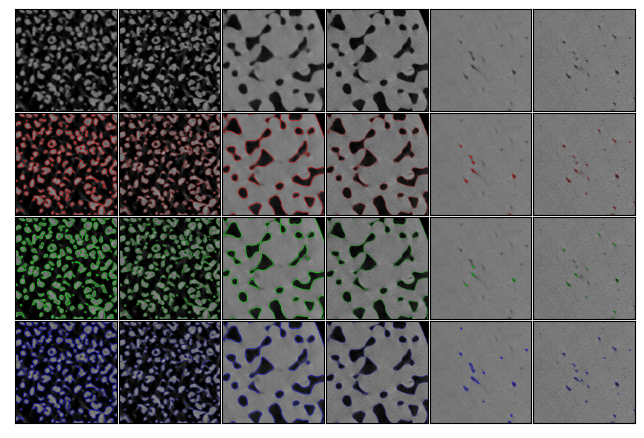

In [11]:
fig = plt.figure(figsize=(8, 12))
gs = fig.add_gridspec(4, 6, hspace=-0.83, wspace=0.02)
ll  = gs.subplots()
#fig.suptitle('Thresholding on High resolution')

for i , ax in enumerate(fig.get_axes()):
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    
    if i%2 == 0:
        ax.imshow(all_images[i][700:900, 1500:1700])
    else:
        ax.imshow(all_images[i][1400:1800, 3000:3400])


for ax in fig.get_axes():
    ax.label_outer()
plt.savefig('multiple_img.png', dpi = 600)